# TensorFlow

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_iris
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from keras.datasets import mnist
%matplotlib inline
import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_eager_execution()
import warnings #ワーニング関連のモジュール？
warnings.filterwarnings('ignore') #ワーニングが消える？

## 【問題1】スクラッチを振り返る

- ノードと呼ばれる層の設定
- 重みの初期化
- 活性化関数の設定
- ミニバッチを生成して局所的な学習

## 【問題2】スクラッチとTensorFlowの対応を考える

In [2]:
"""
TensorFlowで実装したニューラルネットワークを使いIrisデータセットを2値分類する
"""
# データセットの読み込み
iris = load_iris()

# データフレームから条件抽出
#df = df[(df["Species"] == "Iris-versicolor")|(df["Species"] == "Iris-virginica")]
X = pd.DataFrame(iris.data,columns=["sepal_length","sepal_width","petal_length","petal_width"] )
y = pd.DataFrame(iris.target,columns=["Species"])
X = X.loc[0:99,["sepal_length","sepal_width","petal_length","petal_width"]]
y = y.loc[0:99,["Species"]]

y = np.array(y)
X = np.array(X).astype(np.float32)
#print(X)
#print(y)
#y = y.astype(np.float32)[:, np.newaxis]
print(X.shape)
print(y.shape)
# print(X)
# print(y)
# trainとtestに分割
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
# さらにtrainとvalに分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=0)

# 正規化
X_train /= 255
X_test /= 255
X_val /= 255

(100, 4)
(100, 1)


In [3]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ
    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 10, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self.X = X[shuffle_index]
        self.y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self.X[p0:p1], self.y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self.X[p0:p1], self.y[p0:p1]

In [4]:
# ハイパーパラメータの設定
learning_rate = 0.01
batch_size = 10
num_epochs = 100
n_hidden1 = 50
n_hidden2 = 100
n_input = X_train.shape[1]
n_samples = X_train.shape[0]
n_classes = 1

# 空配列定義
X = tf.placeholder("float", [None, n_input])
Y = tf.placeholder("float", [None, n_classes])


# trainのミニバッチイテレータ
get_mini_batch_train = GetMiniBatch(X_train, y_train, batch_size=batch_size)


In [5]:
def MyModel(x): 
        # 重みの定義
        w1 = tf.Variable(tf.random.normal([n_input, n_hidden1]))
        w2 = tf.Variable(tf.random.normal([n_hidden1, n_hidden2]))
        w3 = tf.Variable(tf.random.normal([n_hidden2, n_classes]))
        
        # バイアスの定義
        b1 = tf.Variable(tf.random.normal([n_hidden1]))
        b2 = tf.Variable(tf.random.normal([n_hidden2]))
        b3 = tf.Variable(tf.random.normal([n_classes]))
        
        # 計算グラフ構築（順伝播処理）
        layer_1 = tf.add(tf.matmul(x,w1),b1)
        layer_1 = tf.nn.relu(layer_1)
        layer_2 = tf.add(tf.matmul(layer_1,w2),b2)
        layer_2 = tf.nn.relu(layer_2)
        layer_output = tf.matmul(layer_2,w3) + b3  # tf.addと+は等価である
        return layer_output

In [6]:
# 計算グラフ受け取る
logits = MyModel(X)
# 損失定義
loss_op = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=Y, logits=logits))
# 最適化手法の定義
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
# 最適化手法で、定義した損失を最小化するルールを作成
train_op = optimizer.minimize(loss_op)
# ACC計算
correct_pred = tf.equal(tf.sign(Y - 0.5), tf.sign(tf.sigmoid(logits) - 0.5))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

# 変数を扱うためのおまじない
init = tf.global_variables_initializer()

In [7]:
# tensorflowのセッション開始
with tf.Session() as sess:
    # 初期化
    sess.run(init)
    # 学習回数分ループ
    for epoch in range(num_epochs):
        # ミニバッチイテレータでループ
        for i, (mini_batch_x, mini_batch_y) in enumerate(get_mini_batch_train):
            # 「最適化手法で、定義した損失を最小化するルール」を実行
            sess.run(train_op, feed_dict={X: mini_batch_x, Y: mini_batch_y})
        # 記録
        train_loss, train_acc = sess.run([loss_op, accuracy], feed_dict={X: X_train, Y: y_train})
        val_loss, val_acc = sess.run([loss_op, accuracy], feed_dict={X: X_val, Y: y_val})
        # 仮定出力
        print("Epoch {}, train_loss : {:.4f}, val_loss : {:.4f}, train_acc : {:.3f}, val_acc : {:.3f}".format(epoch, train_loss, val_loss, train_acc, val_acc))
    
    # 学習が終了したらテストデータで実行
    test_acc = sess.run(accuracy, feed_dict={X: X_test, Y: y_test})
    #prediction = sess.run(logits, feed_dict={X: X_test, Y: y_test})
    #print(prediction)
    print("test_acc : {:.3f}".format(test_acc))

2021-09-04 18:05:36.007370: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 0, train_loss : 1.0716, val_loss : 0.8136, train_acc : 0.469, val_acc : 0.625
Epoch 1, train_loss : 1.4281, val_loss : 1.0326, train_acc : 0.469, val_acc : 0.625
Epoch 2, train_loss : 0.7319, val_loss : 0.6372, train_acc : 0.469, val_acc : 0.625
Epoch 3, train_loss : 0.6801, val_loss : 0.6128, train_acc : 0.469, val_acc : 0.625
Epoch 4, train_loss : 0.8448, val_loss : 0.6568, train_acc : 0.469, val_acc : 0.625
Epoch 5, train_loss : 0.8982, val_loss : 0.6787, train_acc : 0.469, val_acc : 0.625
Epoch 6, train_loss : 0.7318, val_loss : 0.5820, train_acc : 0.469, val_acc : 0.625
Epoch 7, train_loss : 0.6930, val_loss : 0.5541, train_acc : 0.469, val_acc : 0.625
Epoch 8, train_loss : 0.7339, val_loss : 0.5655, train_acc : 0.469, val_acc : 0.625
Epoch 9, train_loss : 0.7382, val_loss : 0.5605, train_acc : 0.469, val_acc : 0.625
Epoch 10, train_loss : 0.6860, val_loss : 0.5250, train_acc : 0.469, val_acc : 0.625
Epoch 11, train_loss : 0.6484, val_loss : 0.4977, train_acc : 0.469, val_ac

## 【問題3】3種類すべての目的変数を使用したIrisのモデルを作成

## データ準備

In [8]:
X = pd.DataFrame(iris.data,columns=["sepal_length","sepal_width","petal_length","petal_width"] )
y = pd.DataFrame(iris.target,columns=["Species"])

In [9]:
X = np.array(X)
y = np.array(y)

In [10]:
print(X.shape)
print(y.shape)

(150, 4)
(150, 1)


In [11]:
# 訓練データ、テストデータ、評価データに分割
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=0)

# onehotベクトル化
enc = OneHotEncoder(handle_unknown='ignore',sparse=False)
y_train_one_hot = enc.fit_transform(y_train)
# print(y_train)
# print(y_train_one_hot)
y_val_one_hot = enc.transform(y_val)
# print("--------")
# print(y_val)
# print(y_val_one_hot)
y_test_one_hot = enc.transform(y_test)
# print("--------")
# print(y_test)
# print(y_test_one_hot)

In [12]:
# 正規化
X_train /= 255
X_test /= 255
X_val /= 255
#print(X_train)

## tensorflowで学習

In [13]:
# 変数定義
# 学習率
leaning_rate = 0.01
# バッチのサイズ
batch_size = 10
# 学習回数
num_epochs = 100
# １つ目のノード数
n_hidden1 = 50
# ２つ目のノード数
n_hidden2 = 100
# 出力するサイズ
n_input = X_train.shape[1] #4

#n_samples = X_train.shape[0]
# 多値分類（３種類）のため
n_classes = 3

In [14]:
# 空の配列を作る
X = tf.placeholder("float",[None,n_input])
y = tf.placeholder("float",[None,n_classes])

In [15]:
print(X.shape)
print(y.shape)

(None, 4)
(None, 3)


In [16]:
# ミニバッチイテレータ作成
get_mini_batch_train = GetMiniBatch(X_train,y_train_one_hot,batch_size=batch_size)

In [17]:
def example_net(x):
    """tensorflowを利用したニューラルネットワーク
    --------
    x : 入力配列
    """
    # 重みの定義
    # tf.random.normal = 正規分布から乱数を出力
    # tf.variable = 変数に値を代入する
    w1 = tf.Variable(tf.random.normal([n_input, n_hidden1]))
    w2 = tf.Variable(tf.random.normal([n_hidden1,n_hidden2]))
    w3 = tf.Variable(tf.random.normal([n_hidden2,n_classes]))
    
    # バイアスの定義
    b1 = tf.Variable(tf.random.normal([n_hidden1]))
    b2 = tf.Variable(tf.random.normal([n_hidden2]))
    b3 = tf.Variable(tf.random.normal([n_classes]))
    
    # 計算グラフの構築
    layer_1 = tf.add(tf.matmul(x,w1),b1)
    layer_1 = tf.nn.relu(layer_1)
    layer_2 = tf.add(tf.matmul(layer_1,w2),b2)
    layer_2 = tf.nn.relu(layer_2)
    layer_output = tf.add(tf.matmul(layer_2,w3),b3)
    
    return layer_output

In [18]:
# 計算グラフを受け取る
logits = example_net(X)
# 損失定義
# ２値分類からの変更点
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels = y, logits=logits))
# 最適化手法の定義
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
# 最適化手法で、定義した損失を最小化するルールを作成
train_op = optimizer.minimize(loss_op)
# ACC計算
# ２値分類との違い
# tf.signは要素ごとに数字の符号を返す
# tf.equalは２つの引数の要素ごとの真偽値を返す
correct_pred = tf.equal(tf.argmax(y,1), tf.argmax(logits,1))
# tf.reduce_mean = Tensorの要素の平均を計算
# tf.cast( 変換したいもの , 変換後の型 )
accuracy = tf.reduce_mean(tf.cast(correct_pred,tf.float32))

# 変数の初期化という操作を行っており，計算グラフに変数が含まれている場合は，実行する必要があります．
init = tf.global_variables_initializer()

In [19]:
# tensorflowのSession開始
with tf.Session() as sess:
    # 初期化
    # 必須
    sess.run(init)
    # 学習回数分ループ
    for epoch in range(num_epochs):
        # ミニバッチイテレータでループ
        for i,(mini_batch_x,mini_batch_y) in enumerate(get_mini_batch_train):
            # ここで「最適化手法で、定義した損失を最小化するルール」を実行
            sess.run(train_op,feed_dict={X: mini_batch_x, y: mini_batch_y})
        # 記録
        train_loss,train_acc = sess.run([loss_op,accuracy],feed_dict={X: X_train,y: y_train_one_hot})
        val_loss,val_acc = sess.run([loss_op,accuracy],feed_dict={X: X_val,y: y_val_one_hot})
        # 仮定出力
        print("{}回目:train_loss:{:.4f},val_loss:{:.4f},train_acc:{:.3f},val_acc:{:.3f}".format(epoch,train_loss,val_loss,train_acc,val_acc))
        
    # 学習が終了したらテストデータで実行
    test_acc = sess.run(accuracy,feed_dict={X:X_test, y:y_test_one_hot})
    print("test_acc:{:.3f}".format(test_acc))

0回目:train_loss:2.0572,val_loss:1.9764,train_acc:0.323,val_acc:0.333
1回目:train_loss:1.6237,val_loss:1.6354,train_acc:0.365,val_acc:0.375
2回目:train_loss:0.8274,val_loss:0.8389,train_acc:0.677,val_acc:0.625
3回目:train_loss:0.8876,val_loss:0.8894,train_acc:0.688,val_acc:0.708
4回目:train_loss:0.8173,val_loss:0.8307,train_acc:0.562,val_acc:0.583
5回目:train_loss:0.8883,val_loss:0.9154,train_acc:0.604,val_acc:0.625
6回目:train_loss:0.7846,val_loss:0.7938,train_acc:0.562,val_acc:0.583
7回目:train_loss:0.7102,val_loss:0.7173,train_acc:0.854,val_acc:0.792
8回目:train_loss:0.7125,val_loss:0.7266,train_acc:0.604,val_acc:0.625
9回目:train_loss:0.6795,val_loss:0.6868,train_acc:0.750,val_acc:0.708
10回目:train_loss:0.6561,val_loss:0.6651,train_acc:0.802,val_acc:0.792
11回目:train_loss:0.6319,val_loss:0.6406,train_acc:0.927,val_acc:0.958
12回目:train_loss:0.6114,val_loss:0.6196,train_acc:0.927,val_acc:0.958
13回目:train_loss:0.5926,val_loss:0.6006,train_acc:0.927,val_acc:0.958
14回目:train_loss:0.5722,val_loss:0.5801,train

## 【問題4】House Pricesのモデルを作成

回帰問題のデータセットであるHouse Pricesを使用したモデルを作成してください。

### データ準備

In [20]:
csv_path = "train.csv" # ファイル名（パス）を指定する

'''学習用データの読み込み'''
df = pd.read_csv("train.csv")

y = df["SalePrice"]
X = df.loc[:,["GrLivArea","YearBuilt"]]
y = np.array(y)
X = np.array(X)
print(y.shape)
print(X.shape)
# newaxis = 次元を増やす
y = y.astype(np.int)[:,np.newaxis]
# np.logで対数変換
y = np.log(y)
print(y.shape)
print(y)
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)
X_train,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=0)

(1460,)
(1460, 2)
(1460, 1)
[[12.24769432]
 [12.10901093]
 [12.31716669]
 ...
 [12.49312952]
 [11.86446223]
 [11.90158345]]


### Tensorflowで学習

In [21]:
# 変数定義
learning_rate = 0.001
batch_size = 10
num_epochs = 10
n_hidden1 = 50
n_hidden2 = 100
n_input = X_train.shape[1]
n_classes = 1

# 空の配列
X = tf.placeholder("float",[None,n_input])
y = tf.placeholder("float",[None,n_classes])

# ミニバッチイテレータ生成
get_mini_batch_train = GetMiniBatch(X_train,y_train,batch_size=batch_size)

In [22]:
def example_net(x):
    """
    tensorflowを利用したニューラルネットワーク
    --------
    X : 入力配列
    """
    # 重みの定義
    w1 = tf.Variable(tf.random_normal([n_input,n_hidden1]))
    w2 = tf.Variable(tf.random_normal([n_hidden1,n_hidden2]))
    w3 = tf.Variable(tf.random_normal([n_hidden2,n_classes]))
    
    # バイアスの定義
    b1 = tf.Variable(tf.random_normal([n_hidden1]))
    b2 = tf.Variable(tf.random_normal([n_hidden2]))
    b3 = tf.Variable(tf.random_normal([n_classes]))
    
    # 計算グラフ構築
    layer_1 = tf.add(tf.matmul(x,w1),b1)
    layer_1 = tf.nn.relu(layer_1)
    layer_2 = tf.add(tf.matmul(layer_1,w2),b2)
    layer_2 = tf.nn.relu(layer_2)
    layer_output = tf.add(tf.matmul(layer_2,w3),b3)
    
    return layer_output

In [23]:
# 計算グラフを受け取る
logits = example_net(X)
# 損失定義
loss_op = tf.losses.mean_squared_error(labels=y,predictions=logits)
# 最適化手法の定義
optimizer = tf.train.AdamOptimizer(learning_rate =learning_rate)
# 最適化手法で、定義した損失を最小化するルールを作成
train_op = optimizer.minimize(loss_op)

# 変数の初期化という操作を行っており，計算グラフに変数が含まれている場合は，実行する必要があります．
init = tf.global_variables_initializer()

0回目/loss:1793203.6250,val_loss:1856748.7500
1回目/loss:452947.8750,val_loss:455438.4688
2回目/loss:246724.8594,val_loss:214348.0000
3回目/loss:161734.5625,val_loss:130783.8203
4回目/loss:109299.4766,val_loss:83131.7188
5回目/loss:78729.7734,val_loss:56498.0938
6回目/loss:62072.3828,val_loss:43247.2734
7回目/loss:52154.7227,val_loss:36275.9492
8回目/loss:45263.7422,val_loss:31973.5957
9回目/loss:39835.3242,val_loss:28739.6074


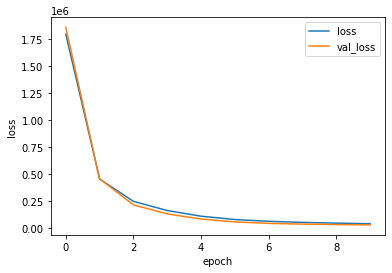

test_mse : 424884.594


In [24]:
# tensorflowのSession開始
with tf.Session() as sess:
    # 初期化
    sess.run(init)
    # 損失記録用
    loss_list = []
    val_loss_list = []
    # 学習回数ループ
    for epoch in range(num_epochs):
        # ミニバッチイテレータでループ
        for i,(mini_batch_x,mini_batch_y) in enumerate(get_mini_batch_train):
            # 「最適化手法で、定義した損失を最小化するルール」を実行
            sess.run(train_op,feed_dict={X: mini_batch_x, y: mini_batch_y})
        # 損失計算
        loss = sess.run(loss_op,feed_dict = {X:X_train,y: y_train})
        val_loss = sess.run(loss_op,feed_dict = {X: X_val, y: y_val})
        # 格納
        loss_list.append(loss)
        val_loss_list.append(val_loss)
        print("{}回目/loss:{:.4f},val_loss:{:.4f}".format(epoch,loss,val_loss))
    
    # 学習過程可視化
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.plot(loss_list, label='loss')
    plt.plot(val_loss_list, label='val_loss')
    plt.legend()
    plt.show()
#     # テストデータに適用    
    test_loss = sess.run(loss_op, feed_dict={X: X_test, y: y_test})
    print("test_mse : {:.3f}".format(test_loss))

## 【問題5】MNISTのモデルを作成

ニューラルネットワークのスクラッチで使用したMNISTを分類するモデルを作成してください。


3クラス以上の分類という点ではひとつ前のIrisと同様です。入力が画像であるという点で異なります。


スクラッチで実装したモデルの再現を目指してください。

In [25]:
# データ読み込み
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# 画像データ→行データに
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

# 正規化
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255

# 変形
y_train = y_train.astype(np.int)[:, np.newaxis]
y_test = y_test.astype(np.int)[:, np.newaxis]

# one-hotベクトル化
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:])
y_test_one_hot = enc.fit_transform(y_test[:])

# 分割
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_one_hot, test_size=0.2)

### Tensorflowで学習

In [26]:
# 変数の定義
learning_rate = 0.003
batch_size = 1
num_epochs = 20
n_hidden1 = 50
n_hidden2 = 100
n_input = X_train.shape[1]
# 2値分類との違い
n_classes = 10

In [27]:
# 空の配列を生成
X = tf.placeholder("float",[None,n_input])
y = tf.placeholder("float",[None,n_classes])

In [28]:
# ミニバッチイテレータ生成
get_mini_batch_train = GetMiniBatch(X_train[:1000],y_train[:1000],batch_size=batch_size)

In [29]:
def example_net(x):
    """
    Tensorflowを利用したニューラルネットワーク
    --------
    x : 入力配列
    """
    # 重みの定義
    w1 = tf.Variable(tf.random_normal([n_input,n_hidden1]))
    w2 = tf.Variable(tf.random_normal([n_hidden1,n_hidden2]))
    w3 = tf.Variable(tf.random_normal([n_hidden2,n_classes]))
    
    # バイアスの定義
    b1 = tf.Variable(tf.random_normal([n_hidden1]))
    b2 = tf.Variable(tf.random_normal([n_hidden2]))
    b3 = tf.Variable(tf.random_normal([n_classes]))
    
    # 計算グラフ構築
    layer_1 = tf.add(tf.matmul(x,w1),b1)
    layer_1 = tf.nn.relu(layer_1)
    layer_2 = tf.add(tf.matmul(layer_1,w2),b2)
    layer_2 = tf.nn.relu(layer_2)
    layer_output = tf.add(tf.matmul(layer_2,w3),b3)
    
    return layer_output

In [30]:
# 計算グラフを受け取る
logits = example_net(X)
# 損失定義
# 2値分類との違い
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=y,logits=logits))
# 最適化手法の定義
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
# 最適化手法で、定義した損失を最小化するルールを作成
train_op = optimizer.minimize(loss_op)
# ACC計算
# 2値分類との違い
correct_pred = tf.equal(tf.argmax(y,1),tf.argmax(logits,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred,tf.float32))

# 変数の初期化という操作を行っており，計算グラフに変数が含まれている場合は，実行する必要があります．
init = tf.global_variables_initializer()

In [31]:
# tensorflowのsession開始
with tf.Session() as sess:
    # 初期化
    sess.run(init)
    # 学習分だけループ
    for epoch in range(num_epochs):
        # ミニバッチイテレータでループ
        for i,(mini_batch_x,mini_batch_y) in enumerate(get_mini_batch_train):
            # 「最適化手法で、定義した損失を最小化するルール」を実行
            sess.run(train_op,feed_dict={X:mini_batch_x,y:mini_batch_y})
        # 記録
        train_loss,train_acc = sess.run([loss_op,accuracy],feed_dict={X:X_train,y:y_train})
        val_loss,val_acc = sess.run([loss_op,accuracy],feed_dict={X:X_val,y:y_val})
        # 仮定出力
        print("{}回目/train_loss:{:.4f},val_loss:{:.4f},train_acc:{:.3f},val_acc:{:.3f}".format(epoch,train_loss,val_loss,train_acc,val_acc))
        
    # 学習が終了したらテストデータで実行
    test_acc = sess.run(accuracy,feed_dict={X:X_test,y:y_test_one_hot})
    print("--------")
    print("test_acc:{:.3f}".format(test_acc))
                

0回目/train_loss:32.4214,val_loss:32.8632,train_acc:0.610,val_acc:0.612
1回目/train_loss:21.7742,val_loss:22.0962,train_acc:0.687,val_acc:0.687
2回目/train_loss:20.8667,val_loss:20.8545,train_acc:0.697,val_acc:0.696
3回目/train_loss:19.5480,val_loss:19.2272,train_acc:0.724,val_acc:0.727
4回目/train_loss:17.5583,val_loss:17.3489,train_acc:0.749,val_acc:0.748
5回目/train_loss:17.8939,val_loss:17.8153,train_acc:0.757,val_acc:0.757
6回目/train_loss:18.7267,val_loss:17.8834,train_acc:0.763,val_acc:0.761
7回目/train_loss:18.2683,val_loss:17.7615,train_acc:0.781,val_acc:0.778
8回目/train_loss:17.9142,val_loss:17.4564,train_acc:0.793,val_acc:0.789
9回目/train_loss:18.8882,val_loss:18.7072,train_acc:0.782,val_acc:0.778
10回目/train_loss:20.0908,val_loss:19.8965,train_acc:0.785,val_acc:0.786
11回目/train_loss:17.0971,val_loss:17.0514,train_acc:0.817,val_acc:0.814
12回目/train_loss:18.9296,val_loss:18.8236,train_acc:0.803,val_acc:0.793
13回目/train_loss:20.0733,val_loss:20.4545,train_acc:0.807,val_acc:0.802
14回目/train_loss: